In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
sys.path.append("../")

from ddpm.pipeline import DDPMPipeline

In [3]:
pipe = DDPMPipeline.from_checkpoint("../fashionmnist1/").to("cuda")

In [62]:
output = pipe(
    num_images=1,
    image_size=32,
    output_samples=True
)

  1%|          | 10/1000 [00:00<00:10, 96.18it/s]

100%|██████████| 1000/1000 [00:10<00:00, 98.44it/s]


In [63]:
def make_video(arrays):
    import imageio
    import numpy as np
    from PIL import Image


    arrays = [array.permute((1, 2, 0)).squeeze(-1) * 255 for array in arrays]
    arrays = [array.cpu().numpy().astype(np.uint8) for array in arrays]


    arrays = [Image.fromarray(array).resize((256, 256), 0) for array in arrays]

    # Convert tensors to numpy arrays and ensure they are in uint8 format
    # images = [array.numpy().astype(np.uint8) for array in arrays]
    images = [np.array(array) for array in arrays]

    # Create a video writer object using imageio
    writer = imageio.get_writer('output_video.mp4', fps=120)  # You can change fps to your desired frame rate

    # Write each frame to the video
    for img in images:
        writer.append_data(img)

    # Close the writer to finalize the video
    writer.close()    

In [64]:
make_video([sample[0] for sample in output.samples[::-1]])

In [65]:
len(output.samples)

1000

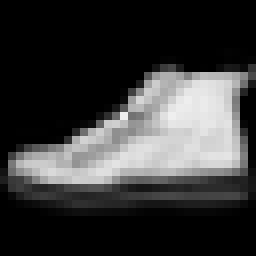

In [66]:
output.images[0].resize((256, 256), 0)